In [1]:
#Classification of MNIST dataset 
push!(LOAD_PATH, "/home/jberez/Projects/OptDigits/dockerxorn")

using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Random
using Distances
using Flux
using StatsBase
using MultivariateStats
using IterTools #Only for plots, not for program
using Serialization
using BNN

include("dockerxorn/utils.jl");
#include("dockerxorn/LoadData.jl");

┌ Info: Precompiling BNN [top-level]
└ @ Base loading.jl:1260


In [2]:
folder = "/Data/XORN/"
traces = []
tests = [i for i=1:16]
#filename_pre = "trace"
filename_pre = "XORNtrace"
filename_end = "output.jld"

good_traces = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
#good_traces = [1,2,3,4]

for i in good_traces
    current_file = join([pwd(),folder,filename_pre,"$(tests[i])", filename_end])
    current_traces = deserialize(current_file)
    push!(traces,current_traces)
end;
chains = length(traces);

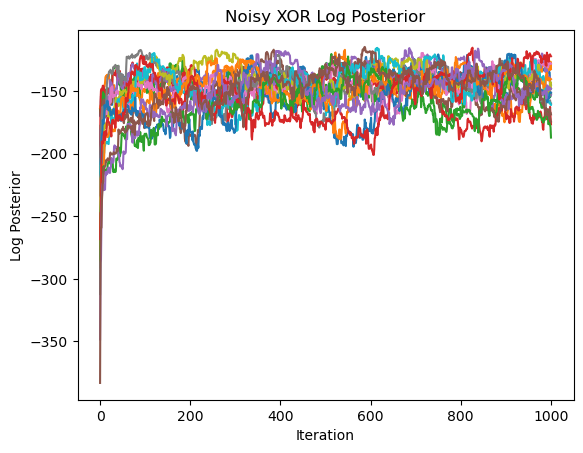

In [3]:
#Plot Log Posterior for Each Chain

for i=1:chains
    scores = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        scores[j] = get_score(trace)
    end
    plot(scores,label="Chain $i")
end
plt.title("Noisy XOR Log Posterior")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");
#plt.ylim(-500,-100)

#legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0);

In [5]:
linear_traces = []
for i in 1:16
    for j in 1:length(traces[i])
        push!(linear_traces,traces[i][j])
    end
end
println("Number of traces: $(length(linear_traces))")

Number of traces: 16016


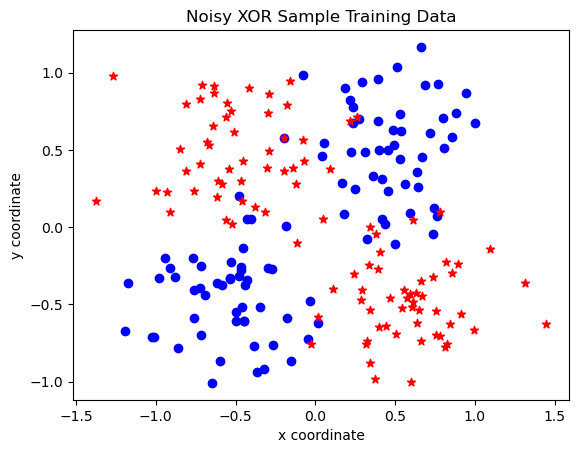

In [9]:
#---------
#Test Data
#---------

#Data hyperparameters
c = 2
n = 50 #Number of samples per mode (classifier)
m = 4 #Number of modes (classifier)
d = 2 #Input dimension
N = n*m #Total samples
σₐ = 0.08 #Mode variance (classifier)
bound = 0.5

#Node hyperparameters
k_range = 16 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]

x_raw, classes = real_data_classifier(Int(N/4), 4, bound, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]
y = classes

plot_data_classifier(x_raw,classes)
xt = transpose(x_raw)
size(xt)

#One-Hot Encode Y
yt = Flux.onehotbatch(y,[:1,:2]);

#Test Set
x_raw_test, classes_test = real_data_classifier(Int(N/4), 4, bound, σₐ);
xt_test = transpose(x_raw_test)
classes_test = [(i+1) % 2 + 1 for i in classes]
y_test = classes_test
yz = y_test
yzt = Flux.onehotbatch(yz,[:1,:2]);

plt.title("Noisy XOR Sample Training Data")
plt.xlabel("x coordinate")
plt.ylabel("y coordinate");

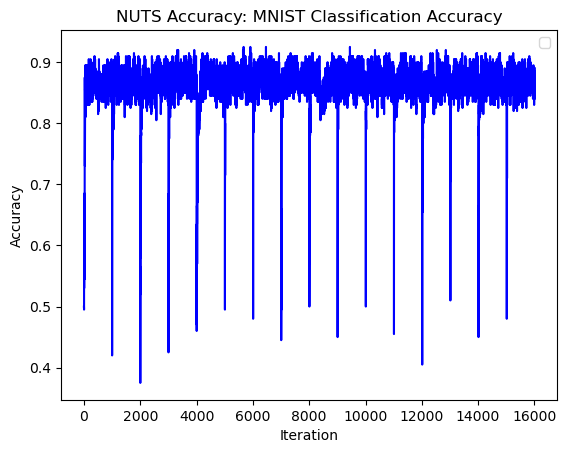

No handles with labels found to put in legend.


In [10]:
#Plot Training Accuracy
traces_master = traces
traces = linear_traces

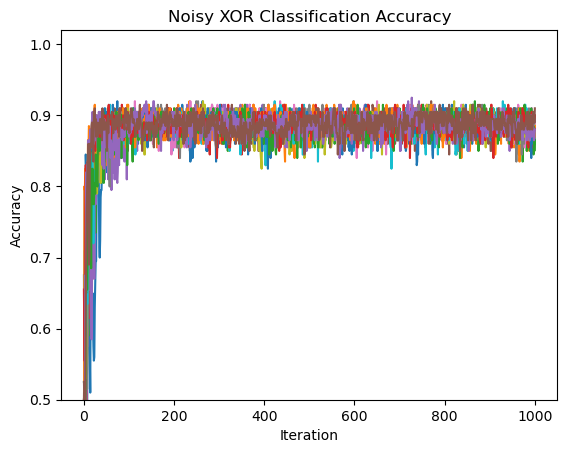

In [36]:
#Plot Training Accuracy

for i=1:chains
    accs2 = []
    scores = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        test_labels = G(xt,trace)
        results = label_output(test_labels)
        test_acc = sum([y_test[i] == results[i] for i=1:length(y_test)])/length(y_test)
        push!(accs2,test_acc)
    end
    plot(accs2,label="Chain $i")
end
plt.title("Noisy XOR Classification Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.ylim(0.5,1.02)

#legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0);

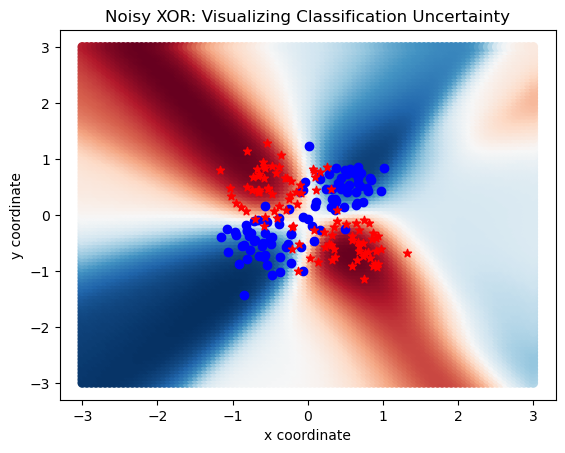

PyObject Text(24.000000000000007, 0.5, 'y coordinate')

In [31]:
function plot_grid(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores,alpha=alpha,cmap="RdBu")
    #PyPlot.colorbar()
end

function tracegrid(traces, samples=2500, low=-3.0, high=3.0)
    d=2
    n=100
    starting_iter = 200
    r = range(low, high, length = n)
    
    iter = Iterators.product((r for _ in 1:d)...)
    grid= vec([collect(i) for i in iter])
    grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
    grid2 = transpose(grid_raw)
    z_master = zeros(length(grid2[1,:]))
    
    for i=1:samples
        j = rand((starting_iter,length(traces)))
        trace = traces[j]
        z = G(grid2,trace)[1,:]
        #display(z)
        z_master += (z ./ samples)
    end
    plot_grid(grid_raw, z_master)
end

tracegrid(traces)
plot_data_classifier(x_raw,classes)

plt.title("Noisy XOR: Visualizing Classification Uncertainty")
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")

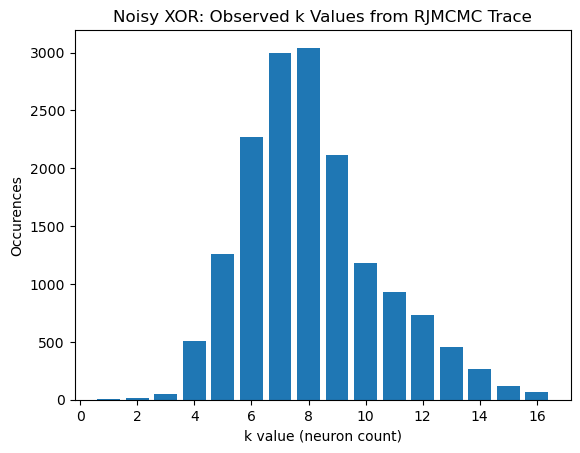

In [39]:
#Hidden Node Counts
traces = traces_master
k_list = [i for i in 1:16]

ls = [[traces[i][j][(:k,1)] for j=1:length(traces[i])] for i=1:chains]
ls = collect(Iterators.flatten(ls))

counts = [sum([k_list[ls[i]] == j for i in 1:length(ls)]) for j in k_list]
bar(k_list,counts)

plt.title("Noisy XOR: Observed k Values from RJMCMC Trace")
plt.xlabel("k value (neuron count)")
plt.ylabel("Occurences");

In [10]:
#Marginalize Probabilities - Train Set
j = 1
c = 2
N = 200
total_count = sum([length(traces[i]) for i=1:chains])
targets = zeros(total_count-(chains*j),c,N)
for v=1:chains
    active_traces = traces[v]
    count = 1
    for i=j:length(active_traces)-j
        trace = active_traces[i]
        labels = G(xt,trace)
        targets[count,:,:] = labels
        count += 1
    end
end

sums = sum(targets,dims=1)[1,:,:]./(total_count)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([y[i] == guesses[i] for i=1:length(y)])
println("Training set accuracy: $test_acc")

Training set accuracy: 182
